In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/jazzer/.pyenv/versions/3.6.10/bin/python (found version "3.6.10") 
-- Found PythonLibs: /home/jazzer/.pyenv/versions/3.6.10/lib/libpython3.6m.a
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/jazzer/Facultad/metodos_numericos_3/mt/tp3
-- Configuring done
-- Generating done
-- Build files have been written to: /home/jazzer/

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10


In [4]:
df = pd.read_csv('../data/train.csv')

In [5]:
df = df[df['ciudad']=='Mérida'].dropna()

In [30]:
x = df[['metroscubiertos']].values

In [31]:
y = df['precio'].values

In [32]:
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

In [33]:
x.shape

(518, 1)

In [34]:
from sklearn.linear_model import LinearRegression

"""
Reemplazar por nuestra implementación 
"""

#linear_regressor = LinearRegression()
linear_regressor = metnum.LinearRegression()

linear_regressor.fit(x,y)

In [35]:
df['prediction'] = linear_regressor.predict(x)

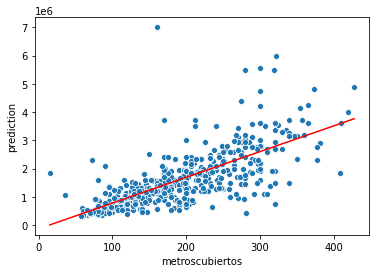

In [36]:
sns.scatterplot(data=df, x='metroscubiertos', y='precio')
sns.lineplot(data=df, x='metroscubiertos', y='prediction', color='red')


/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
0.7

--------------

0.7999999999999999

--------------

0.8999999999999999

--------------

0.9999999999999999

--------------

{'rmse': [0.2870927295996959, 0.2870278414920376, 0.28668753201300146, 0.9210125674450729], 'rmsle': [0.11661798652200035, 0.11660243323392647, 0.11646828499414043, 0.3667313247576295], 'percentage_of_train_cases': [0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999]}


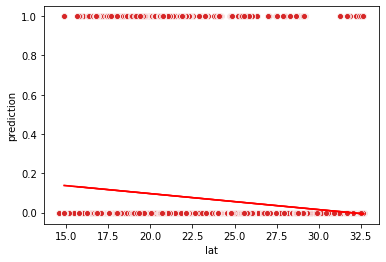

In [71]:

import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *

!pwd
!python --version
import metnum

def calculate_metrics(variable_to_predict, df):
    df = df[df['prediction'].notna()]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))


def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df,
         data):
    
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))

    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy()
    df = df[:TOTAL_TRAIN_CASES]
    
#     print('length df: '+ str(len(df)))
#     print('length df_prediction: '+ str(len(df_prediction)))
#     print(df['lat'].sort_values().unique())
#     print(df['piscina'].unique()) 
#     print(df[df['lat'].isnull()])
#     print(df[df['piscina'].isnull()])

    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction
    
df = pd.read_csv('../data/train.csv')

# print(df.info()) 
df = df[df['lat'].notna()]
df = df[df['lat']<33]
df = df[df['lat']>14]

# df = df[df['ciudad']=='Mérida'].dropna()

d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : []}

folder='./test_{}'.format(int(time.time()))

os.mkdir(folder)

for i in np.arange(0.7, 1.0, 0.1):
    print(i)
    df_prediction = experiment(i, 'piscina', ['lat'], 666, df, d)
    df_prediction.to_csv(folder+'/prediction'+'_'+str(i)+'.csv', encoding='utf-8', index=False)
    print('\n--------------\n')
    
print(d)

(pd.DataFrame(data=d)
   .to_csv(folder+'/error.csv', encoding='utf-', index=False))
